<a href="https://colab.research.google.com/github/erikrozi/acmlab/blob/main/unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in the Shared Google Drive
FOLDERNAME = 'Shared drives/Unsupervised'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/{}'.format(FOLDERNAME))

%cd /content/drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/Shared drives/Unsupervised


In [4]:
# Importing the standard ML libraries...
%load_ext autoreload
%autoreload 2

import pandas as pd                     # to process our data
import matplotlib.pyplot as plt         # graphing
import numpy as np                      # matrices

import torch
import torchvision                      # for MNIST dataset/working with images

import math

# take advantage of GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Census Data

In [5]:
# Loads data with zip and aveincome
tax_returns_data = pd.read_csv("16zpallnoagi.csv")
cleaned_tax_data = pd.DataFrame(tax_returns_data, columns = ["ZIPCODE", "N1", "A02650"])
cleaned_tax_data = cleaned_tax_data[(cleaned_tax_data['ZIPCODE'] <= 97000) & (cleaned_tax_data['ZIPCODE'] >= 90000)] #remove zipcodes not in california
cleaned_tax_data.columns = ['zip', 'N1', 'A02650']
cleaned_tax_data['aveincome'] = ((cleaned_tax_data['A02650'] / cleaned_tax_data['N1']) * 1000).astype(np.int32)

In [6]:
# Loads zips for Los Angeles
ziplation_data = pd.read_csv("ziplatlon.csv", sep = ";")
parsed_ziplation_data = ziplation_data[(ziplation_data['latitude'] <= 34.3) & (ziplation_data['latitude'] >= 33.5) & (ziplation_data['longitude'] >= -118.6) & (ziplation_data['longitude'] <= -117.6)]
parsed_ziplation_data = pd.merge(parsed_ziplation_data, cleaned_tax_data, how='left', on= 'zip')
parsed_ziplation_data = parsed_ziplation_data.dropna()

In [7]:
import util as util
import webmercator as webmercator

In [8]:
# creates image data and pulls latitude and longitude
z = 14
pos = np.empty([1980, 5])
for x in range(2794, 2839):
  for y in range(6528, 6572):
    curPos = (x - 2794) * (6572 - 6528) + (y - 6528)
    pos[curPos, 0] = x
    pos[curPos, 1] = y
    pos[curPos, 2] = webmercator.lat(y, z)
    pos[curPos, 3] = webmercator.lon(x, z)
    pos[curPos, 4] = util.getElevation(pos[curPos, 2], pos[curPos, 3])
image_pos_data = pd.DataFrame({'x': pos[:,0].astype(int), 'y': pos[:,1].astype(int), 'z': 14, 'latitude': pos[:,2], 'longitude': pos[:,3], 'elevation': pos[:,4]})
image_pos_data['img'] = "14_" + image_pos_data['x'].astype(str) + "_" + image_pos_data['y'].astype(str) + ".jpg"

Maps image to closest zip code

In [9]:
def calc_distance(lat1, long1, lat2, long2):
  xdist = long1 - long2
  ydist = lat1 - lat2
  return math.sqrt(xdist**2 + ydist**2)

In [10]:
np_ziplation = parsed_ziplation_data.to_numpy()
tile_zips = np.empty([image_pos_data.shape[0], 1])

np_ziplation.shape

#very inefficient lol
#for each image tile, loops through all the possible zipcodes, and chooses the one with the smallest distance
for i in range(image_pos_data.shape[0]):
  min_dist = 100000 #just made this an arbitrarily large number cuz iwas lazy
  for j in range(np_ziplation.shape[0]):
    zip_coords = np_ziplation[j][7].split(",") #splitting geopoint coords into latitude and longitude
    pt = image_pos_data['latitude'][i]
    cur_dist = calc_distance(pt, image_pos_data['longitude'][i], float(zip_coords[0]), float(zip_coords[1]))
    if cur_dist < min_dist:
      min_dist = cur_dist
      tile_zips[i] = np_ziplation[j][0]
image_pos_data['zipcode'] = tile_zips.astype(np.int32)

In [11]:
# Gets rid of ocean tiles
image_pos_data = image_pos_data[~(image_pos_data['elevation'] == 0)]

In [16]:
image_income_data = pd.DataFrame(image_pos_data, columns = ['img', 'zipcode'])
image_income_data.columns = ['img', 'zip']
image_income_data = pd.merge(image_income_data, cleaned_tax_data, how='left', on='zip')
image_income_data

,img,zip,N1,A02650,aveincome
0,14_2794_6528.jpg,91311,18560,1694366,91291
1,14_2794_6529.jpg,91311,18560,1694366,91291
2,14_2794_6530.jpg,91311,18560,1694366,91291
3,14_2794_6531.jpg,91311,18560,1694366,91291
4,14_2794_6532.jpg,91311,18560,1694366,91291
...,...,...,...,...,...
1452,14_2838_6567.jpg,92692,23430,2676168,114219
1453,14_2838_6568.jpg,92694,11460,2027274,176900
1454,14_2838_6569.jpg,92694,11460,2027274,176900
1455,14_2838_6570.jpg,92694,11460,2027274,176900


In [17]:
# Remove the unnecessary columns beside image url & average income
image_income_data = image_income_data[['img', 'aveincome', 'zip']]
image_income_data

,img,aveincome,zip
0,14_2794_6528.jpg,91291,91311
1,14_2794_6529.jpg,91291,91311
2,14_2794_6530.jpg,91291,91311
3,14_2794_6531.jpg,91291,91311
4,14_2794_6532.jpg,91291,91311
...,...,...,...
1452,14_2838_6567.jpg,114219,92692
1453,14_2838_6568.jpg,176900,92694
1454,14_2838_6569.jpg,176900,92694
1455,14_2838_6570.jpg,176900,92694


In [18]:
image_income_data.to_csv('image_income_data.csv')

# Load the imagery data


In [26]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class TileImageryDataset(Dataset):
  """Tile imagery dataset."""

  def __init__(self, csv_file, root_dir, transform=None):
    # Load into tensors
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

    # Perform data augmentation

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    image = Image.open(self.root_dir +  self.annotations.iloc[index,1])
    y_label = torch.tensor(int(self.annotations.iloc[index, 2]))

    if self.transform:
      image = self.transform(image)

    return (image, y_label)

  #def load_images():
  #  tensors = []
  #  for x in range(2794, 2839):
  #    for y in range(6528, 6572):
  #      image = Image.open(f"images/14_{x}_{y}.jpg").convert("RGB")
  #      # TODO change
  #      #jaden
  #      data = asarray(image) #convert to np array, could also do np.array(Image.open...)
  #      data = torch.from_numpy(data) #convert to tensor
  #      preprocess = transforms.Compose([
  #          transforms.Resize(256),
  #          transforms.CenterCrop(224),
  #          transforms.ToTensor(),
  #          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  #      ])
  #      input_tensor = preprocess(image)
  #      # tensory push thing?

In [27]:
from torch.utils.data import Dataset, DataLoader
batch_size = 64

dataset = TileImageryDataset(csv_file = 'image_income_data.csv', root_dir = 'imagery/', transform = transforms.ToTensor())

train_set, test_set = torch.utils.data.random_split(dataset, [1200, 257])

trainloader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle=True)
testloader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle=False)



In [28]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 256, 256])
torch.Size([64])


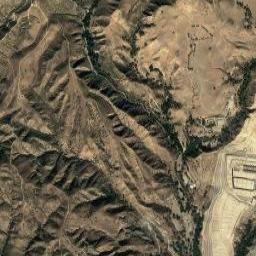

In [29]:
i = 0
image, label = dataset[i]
image = np.moveaxis(image.numpy(), 0, -1)
image = (image * 255).astype(np.uint8)
display(Image.fromarray(image).convert("RGB"))

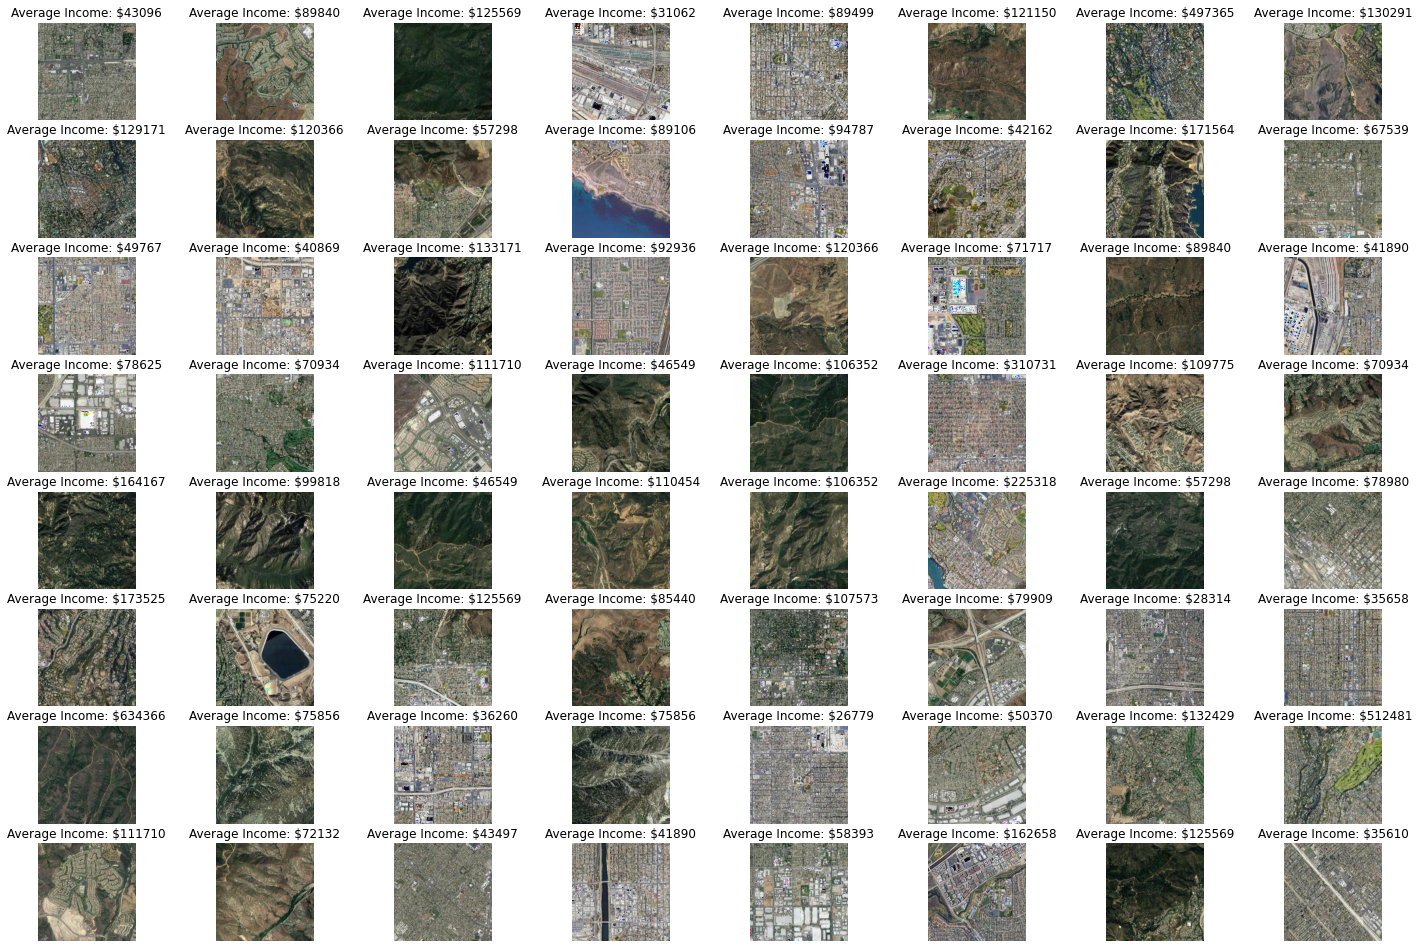

In [30]:
figure = plt.figure(figsize=(25, 10))
plt.subplots_adjust(top=1.4)
num_rows = 8
num_cols = 8
for idx in range(batch_size):
  plt.subplot(num_rows, num_cols, idx + 1) # subplot indices begin at 1, not 0
  plt.axis('off')
  plt.title('Average Income: ${}'.format(labels[idx]))
  image = np.moveaxis(images[idx].numpy(), 0, -1)
  image = (image * 275).astype(np.uint8)
  plt.imshow(image)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvolutionalNeuralNet(nn.Module):
  def __init__(self):
    super(ConvolutionalNeuralNet, self).__init__()
    # Images are 256x256
    self.conv1 = nn.Conv2d(1, 10, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(10, 20, 5)
    self.fc1 = nn.Linear(20 * 4 * 4, 50)
    self.fc2 = nn.Linear(50, 1)

  def forward(self, x):
    x = self.pool(nn.relu(self.conv1(x)))
    x = self.pool(nn.relu(self.conv2(x)))
    x = x.view(-1, 20 * 4 * 4)
    x = self.relu(self.fc(x))
    x = self.fc2(x)
    return x